In [635]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import h5py
import tqdm
import zipfile
from tqdm.notebook import tqdm_notebook
from progress.bar import IncrementalBar
import copy
import random
import pandas as pd
import time
import os
import math
from joblib import Parallel, delayed
# tf.config.run_functions_eagerly(True)
%matplotlib inline
np.set_printoptions(suppress=True)

In [2]:
param_names=['signal','pl_fr','real_wf-pl_fr','mask']

In [3]:
def norming(data,param_names=param_names,log=True):
    
    # ADD LOGARIFM FOR SIGNAL
    norm_params={}
    for i in range(data.shape[-1]):
        if (i==0 and log):
            data[:,:,:,i]=tf.math.log(data[:,:,:,i]+1)
        max_c=data[:,:,:,i].max()
        min_c=data[:,:,:,i].min()
        mean_c=data[:,:,:,i].mean()
        std_c=data[:,:,:,i].std()
        print(max_c,min_c)
        data[:,:,:,i]=(data[:,:,:,i]-min_c)/(max_c-min_c)

        norm_params[param_names[i]]=np.array([max_c,min_c])
    return norm_params
def renormin(data_not_change,norm_params,param_names=param_names,log=True):
    data=np.copy(data_not_change)
    for i in range(data.shape[-1]):
        max_c, min_c=norm_params[param_names[i]]
        data[:,:,:,i]=data[:,:,:,i]*(max_c-min_c) + min_c
        if (i==0 and log):
            data[:,:,:,i]=tf.math.exp(data[:,:,:,i])-1
        elif (i==1 or i==2):
            data[:,:,:,i]=data[:,:,:,i]*1e6
    return data

In [519]:
path='../../mc_hadrons_qgs34_0010.h5'
data_name='pr-q4-9yr'
data=np.zeros((0,6,6,4))
with h5py.File(path,'r') as f:
    print(f[data_name]['dt'].shape)
    data=np.concatenate((data,f[data_name]['dt'][:2000,:,:,3:7]))
    gp=f[data_name]['gp'][()]
    ev_params=f[data_name]['ev_params'][()]
# data=data[1:]
data[:,:,:,1]=data[:,:,:,1]*1e6
data[:,:,:,2]=data[:,:,:,2]*1e6
print('len data: ',len(data))

(268322, 6, 6, 7)
len data:  2000


In [522]:
# new data
path='../../data_01_24.h5'
num_ev=2000
with h5py.File(path,'r') as f:
    data=f['dt_bunlde'][:num_ev,:,:,3:7]
    detectors_rub = f['dt_bunlde'][:num_ev,:,:,:3] * 1.2
    ev_params = f['recos'][:num_ev,:2]
    real_ang = f['mc_params'][:num_ev,4:6]

In [523]:
data[0,:,:,1]

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -2.313, -4.545,  0.   ],
       [ 0.   ,  0.   ,  1.186, -1.155, -3.481,  0.   ],
       [ 0.   ,  0.   ,  2.256, -0.297,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  3.27 ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]], dtype=float32)

# Constant

In [524]:
pi = tf.constant(math.pi)
UNIT=1
dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
c=tf.constant(299792.458,dtype=tf.float32)# # km\s
NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
R_L=30e-3
LINSLEY_r0=0.025
Det_Area=30
tf_type=tf.float32
s_min = tf.constant([[0.3]])
s_max = tf.constant([[1.8]])
t_err_res=c/1e6
t0_err=30

In [525]:
def reduce_saturation(data,ret_sig=True):
    max_signal=tf.reduce_max(data[:,:,:,0])
    signal=data[:,:,:,0]
    mask=data[:,:,:,3]
#     print('old signal \n',signal)
#     print('old mask \n',mask)
    new_mask=tf.where(tf.logical_and(mask!=0,signal==0),0,mask)
    new_signal=tf.where(tf.logical_and(mask!=0,signal==0),max_signal,signal)
    res=tf.where(tf.logical_and(mask!=0,signal==0),1,0)
    print(tf.reduce_sum(res))
    if ret_sig:
        return new_signal
    else:
        return new_mask

In [526]:
# pi = tf.constant(math.pi)
# UNIT=1
# dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
# c=tf.constant(299792.458,dtype=tf.float32)# # km\s
# NSEC= 1e6/c# in rubsov's code is a time for 1.2 km 1.2/c*1e9
# R_L=30e-3
# LINSLEY_r0=0.025
# Det_Area=30
# tf_type=tf.float32
# s_min = tf.constant([[0.3]])
# s_max = tf.constant([[1.8]])
# t_err_res=c/1e6
# t0_err=30
class Reconstruction():
    #constants
    pi = tf.constant(math.pi,dtype=tf.float32)
    UNIT=1
    dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
    c=tf.constant(299792.458,dtype=tf.float32)# # km\s
    NSEC= tf.constant(1e9/c,dtype=tf.float32)# in rubsov's code is a time for 1.2 km 1.2/c*1e9
    R_L=tf.constant(30e-3,dtype=tf.float32)#
    LINSLEY_r0=tf.constant(0.025,dtype=tf.float32)#
    DET_AREA=tf.constant(3,dtype=tf.float32)#
    s_min = tf.constant([[0.3]],dtype=tf.float32)
    s_max = tf.constant([[1.8]],dtype=tf.float32)
    t_err_res=tf.constant(c/1e6,dtype=tf.float32)#
    t0_err=tf.constant(30,dtype=tf.float32)#
    dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
    
    def __init__(self,data,tf_type):
        # all have shape (batch,6,6,1)
        self.tf_type = tf_type
        self.data=tf.cast(data,self.tf_type)
        self.mask = tf.expand_dims(data[:,:,:,3],-1)
        self.signal = tf.expand_dims(data[:,:,:,0],-1)*self.mask
        self.mask = tf.where(self.signal==0,0,self.mask)
        self.real_time = tf.expand_dims((data[:,:,:,1] + data[:,:,:,2]),-1)*self.mask 
        self.signal = tf.cast(self.signal,self.tf_type)
        self.real_time = tf.cast(self.real_time,self.tf_type)
        self.mask = tf.cast(self.mask,self.tf_type)
        self.batch = data.shape[0]
        self.t0 = None
        self.theta = None
        self.detertors_coord = None
        self.core = None
        self.t_place = None
        self.courve = None
        self.R_error = 0.15
        self.S_X=None
        self.LDF=None
#     @classmethod
    def detectors_init(self):
        x = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),0),6,axis=0),self.tf_type)
        y = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),1),6,axis=1),self.tf_type)
        x = tf.expand_dims(x,-1)
        y = tf.expand_dims(y,-1)
        # x.shape = (6,6,1)
        detectors = tf.concat([x,y],axis=-1) * self.dist
        
        #detectors.shape = (batch,6,6,2) in km
        detectors = tf.repeat(tf.expand_dims(detectors,0),self.batch,0)
        self.detertors_coord=detectors
        return detectors
#     @classmethod
    def core_(self):
        detectors = self.detectors_init() # shape (batch,6,6,2)
        sum_signal=tf.reduce_sum(self.signal,axis=(1,2)) # shape (batch ,1)
        core=tf.reduce_sum(detectors * self.signal, axis=(1,2))/sum_signal
        #update self
        self.core = core
        return core
    @staticmethod
    def expand_dims(vec):
        return tf.expand_dims(tf.expand_dims(vec,-1),-1)
    def create_matrix(self,x,y,t,mask):
        a11=self.expand_dims(tf.reduce_sum(x*x,axis=1))
        a12=self.expand_dims(tf.reduce_sum(x*y,axis=1))
        a13=self.expand_dims(tf.reduce_sum(x,axis=1))
        a22=self.expand_dims(tf.reduce_sum(y*y,axis=1))
        a23=self.expand_dims(tf.reduce_sum(y,axis=1))
        a33=self.expand_dims(tf.reduce_sum(mask,axis=1))
        a1=tf.concat([a11,a12,a13],axis=2)
        a2=tf.concat([a12,a22,a23],axis=2)
        a3=tf.concat([a13,a23,a33],axis=2)
        A=tf.concat([a1,a2,a3],axis=1)

        b1=self.expand_dims(tf.reduce_sum(x*t,axis=1))
        b2=self.expand_dims(tf.reduce_sum(y*t,axis=1))
        b3=self.expand_dims(tf.reduce_sum(t,axis=1))
        b=tf.concat([b1,b2,b3],axis=1)
        return A,b
    def place_sol(self):
        real_time=self.real_time
        mask=self.mask
        detectors = self.detectors_core() * mask
        x = tf.reshape(detectors[:,:,:,0],(-1,36))
        y = tf.reshape(detectors[:,:,:,1],(-1,36))
        t = tf.reshape(real_time,(-1,36))
        mask = tf.reshape(mask,(-1,36))
        A,b=self.create_matrix(x,y,t,mask)
        return tf.linalg.solve(A,b)
#     @classmethod
    def place_params(self):
        c = self.c
        pi =self.pi
        sol = self.place_sol()
        #t_0=b+(r_cor;n)
        b=sol[:,2:,0]
        n=sol[:,:2,0]
        core = self.core_()
        mul=n[:,0]*core[:,0]+n[:,1]*core[:,1]
        t0=b
        a_x=n[:,0]
        a_y=n[:,1]
#         print(a_x.dtype,(1e6/c).dtype,c.dtype)
        a_z=tf.math.pow(1e6/c,2) - (tf.math.pow(a_x,2) + tf.math.pow(a_y,2))
        a_z=tf.where(a_z>0,tf.math.sqrt(a_z),0)
        cos_theta=a_z*(c/1e6)
        theta=tf.math.acos(cos_theta)
        tg_phi=a_x/(-a_y)
        atan=tf.math.atan(tg_phi)
        phi=tf.where(a_y>0,atan+pi,atan-pi)
        phi=tf.where(a_x<0,atan,phi)
        phi = tf.math.atan2( -a_x, -a_y )
        # update self
        self.phi = phi
        self.theta = theta
        self.t0=t0
        return t0,tf.expand_dims(theta,-1),tf.expand_dims(phi,-1)
    def detectors_core(self):
        detectors=self.detertors_coord
        core = self.core
        detectors_c=detectors-tf.reshape(core,(-1,1,1,2))
        return detectors_c
    def detectors_core_static(self,core):
        detectors=self.detertors_coord
#         core = self.core
        detectors_c=detectors-tf.reshape(core,(-1,1,1,2))
        return detectors_c
#     @classmethod
    def place_reconstruction(self):
        c = self.c
        t0,theta,phi = self.place_params()
        detectors = self.detectors_core()
        detectors = self.detertors_coord
#         print(detectors)
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)*(1e6/c)
#         print(n)
        t_place =  t0 + detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        t_place = t_place*self.mask
        self.t_place = t_place*self.mask
        return self.t_place
    def place_reconstruction_static(self,t0,theta,phi,core):
        c=self.c
        detectors = self.detectors_core_static(core)
#         detectors = self.detertors_coord
#         detectors = 
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)*(1e6/c)
#         print(n)
        t_place =  t0 + detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        t_place = t_place*self.mask
        self.t_place = t_place*self.mask
        return self.t_place
    @staticmethod
    def eta_fun(theta):
        x=theta*180/3.14

        e1 = 3.97 - 1.79*(tf.math.abs(1.0/tf.math.cos(theta)) - 1.0)
        e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
                   + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
                 + 3.70692527e+00)
        res = tf.where(x<62.7,e1,e2)
        # check
        res =tf.where(res>0,res,0)
        return res
    def s_profile_tasimple(self,r_ta,theta):
        r = r_ta
        eta=self.eta_fun(theta)# batch,1,1
        eta=tf.repeat(eta,6,axis=1)
        eta=tf.repeat(eta,6,axis=2)
        # eta shape is batch,6,6
        Rm = tf.constant(0.09,dtype=tf.float32)
        R1 = tf.constant(1,dtype=tf.float32)
        return (tf.math.pow((r/Rm),-1.2)*tf.math.pow((1+r/Rm), -(eta-1.2))*tf.math.pow(1+(tf.math.pow(r,2)/R1/R1),-0.6))
    def s_profile(self,r_ta, theta):
        #r_ta shape batch,6,6
        f800=self.s_profile_tasimple(self.expand_dims(tf.constant(0.8)), theta)
        return self.s_profile_tasimple(r_ta, theta)/f800
    def pfs__pps(self):
        s_min = self.s_min
        s_max = self.s_max
        t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2] # not has t0
        # end t_place's part
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
        cond_dist = tf.cast(tf.where(tf.logical_and(dist_core>s_min,dist_core<s_max),self.mask,0.),self.tf_type)
        pfs = tf.reduce_sum(self.signal*cond_dist,axis=(1,2))
        pps = tf.reduce_sum(self.s_profile(dist_core,theta)*cond_dist,axis=(1,2))
        return (pfs,pps)
#     @staticmethod
    def a_ivanov_fun(self,theta):
        pi =self.pi
        DEG=pi/180
        threshold1=25*DEG
        threshold2=35*DEG
        # переписать для обнавления масива
        res1=tf.where(theta<threshold1,3.3836 - 0.01848*theta/DEG,0)
        res3=tf.where(theta>threshold2,tf.math.exp(-3.2e-2*theta/DEG + 2.0),0)
        a=(0.6511268210e-4*(theta/DEG-0.2614963683))*(theta/DEG*theta/DEG-134.7902422*theta/DEG+4558.524091)
        res2=tf.where(tf.math.logical_and(theta > threshold1,theta < threshold2),a,0)
        return res1+res2+res3
    
    def courve_fun(self):
        a_ivanov = self.a_ivanov_fun(self.theta)
        pfs,pps = self.pfs__pps()
        # norming
        S_X = tf.where(pps>1e-10,pfs/pps,1)[:,0]
        self.S_X=tf.expand_dims(S_X,-1)
        courve = tf.expand_dims(a_ivanov*1.3/tf.math.sqrt(S_X),axis=-1)
        self.courve = courve
        return courve
#     @staticmethod
    def linsley_t(self,r,S):
        LINSLEY_r0 = self.LINSLEY_r0
        return 0.67*tf.math.pow((1 + r/LINSLEY_r0), 1.5)*tf.math.pow(S, -0.5)/1e3
    def courve_reconstruction(self):
        
        s_min = self.s_min
        s_max = self.s_max
        
        t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
        LDF=self.s_profile(dist_core,theta)
        self.LDF=LDF
        td=self.expand_dims(self.courve)*self.linsley_t(dist_core,LDF)/self.NSEC
        return td
    def courve_reconstruction_static(self,t0,theta,phi,courve,core):
        s_min = self.s_min
        s_max = self.s_max
#         t0,theta,phi = self.place_params()
        # u can read from t_place if in place_reconstruction use core shift
        detectors = self.detectors_core_static(core)
#         ???
        detectors = self.detectors_core()
        t0=self.expand_dims(t0) # shape (batch,1,1,1)
        theta=self.expand_dims(theta)
        phi = self.expand_dims(phi)
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
        t_place = detectors[:,:,:,1:2]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,1:2]
        dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
        # add R-error
        dist_core = tf.where(dist_core>self.R_error*self.R_error,tf.math.sqrt(dist_core),self.R_error)
        LDF=self.s_profile(dist_core,theta)
        self.LDF=LDF
        td=self.expand_dims(courve)*self.linsley_t(dist_core,LDF)/self.NSEC
        return td,LDF
    @staticmethod
    def logPua(n,nbar):
        print(n.shape,nbar.shape)
        last_part = 2*(n*tf.math.log(nbar/(n+1e-8)) + (n - nbar))

        nbar_logical=tf.where(nbar < 1e-90,True,False)
        n_logical1 = tf.where(n>1e-90,True,False)
        res = tf.zeros_like(n)
        res=tf.where(tf.logical_and(nbar_logical,n_logical1),-1e-6,res)

        else_nbar_logical = tf.logical_not(nbar_logical) 
        n_logical2 = tf.where(n<1e-20,True,False)

        res=tf.where(tf.logical_and(else_nbar_logical,n_logical2),-2*nbar,res)
        res=tf.where(tf.logical_and(else_nbar_logical,tf.logical_not(n_logical2)),last_part,res)
        return res
    def chi2L(self,S_X,s_prof):
        mask=self.mask
        s_fit = self.expand_dims(S_X)*s_prof*mask
#         print('SX',self.expand_dims(S_X),'\ns_prof',s_prof[:,:,:,0],'\n sift',s_fit[:,:,:,0])
        qs=self.signal
        s_sigma2 = ( 2*qs/self.DET_AREA + tf.math.pow( 0.15*qs, 2 ) + 1e-6 )
        maskL2 = tf.where(qs>4.0,mask,0)
        S=S_X
#         print(s_fit[:,:,:,0],qs[:,:,:,0])
        chi2L2=tf.reduce_sum((qs - s_fit)*(qs - s_fit)/s_sigma2*maskL2,axis=(1,2))
        maskL3 = tf.where(s_fit<4.0,mask,0)
#         chi2L3 = -tf.reduce_sum(0.4*self.logPua(S*self.DET_AREA, s_fit*self.DET_AREA)*maskL3,axis=(1,2))
#         print(chi2L2.shape,chi3L.shape)
        return chi2L2  #+ chi3L
    def optimization(self,iterats,num):
        Adam = tf.keras.optimizers.Adam()
        # add ch2_L
        self.detectors_init()
        self.core_()
        self.place_sol()
        # ??? don't work without that 
        pfs,pps= rec.pfs__pps()
        rec.courve_fun()
        chi_list=[]
        self.place_params()
        t0=self.t0
        theta=tf.expand_dims(self.theta,-1)
        phi=tf.expand_dims(self.phi,-1)
        core = self.core
        courve= self.courve
        S_X = self.S_X
#         print(S_X)
        par = [t0,theta,phi,courve,core,S_X]
        params=[tf.Variable(p, True) for p in par]
#         params=tf.concat([t0,theta,phi,courve,core,S_X],axis=1)
        params_list=[]
        params_list.append(params)
        for i in tqdm.notebook.tqdm_notebook(range(iterats)):
            with tf.GradientTape() as gr:  
                gr.watch(params)
#                 self.t0=params[:,0:1]
#                 self.theta=params[:,1:2]
#                 self.phi=params[:,2:3]
#                 self.courve=params[:,3:4]
#                 self.core=params[:,4:6]
#                 self.S_X=params[:,6:7]
                
#                 t0=params[:,0:1]
#                 theta=params[:,1:2]
#                 phi=params[:,2:3]
#                 courve=params[:,3:4]
#                 core=params[:,4:6]
#                 S_X=params[:,6:7]
                
                # for list
                self.t0=params[0]
                self.theta=params[1]
                self.phi=params[2]
                self.courve=params[3]
                self.core=params[4]
                self.S_X=params[5]
                
                t0=params[0]
                theta=params[1]
                phi=params[2]
                courve=params[3]
                core=params[4]
                S_X=params[5]
                t_place = self.place_reconstruction_static(t0,theta,phi,core)
                td,LDF = self.courve_reconstruction_static(t0,theta,phi,courve,core)  #update LDF <==> s_profile
                t_sigma2=(self.t0_err*self.t0_err + td*td) * self.t_err_res
                time_reco = t_place +td
                chi_T=tf.reduce_sum(tf.math.pow((time_reco-self.real_time)*self.mask,2)/t_sigma2,axis=(1,2))
                chi_L=self.chi2L(S_X,LDF)
                chi = chi_T +chi_L
                
#                 print(tf.reduce_mean(chi_T),tf.reduce_mean(chi_L),end='\r')
                if num:
                    print(chi_T[num],chi_L[num],[np.array(i[num]) for i in params],end='\r')
                chi_list.append(chi)
                grad=gr.gradient(chi,params)
#                 grad = grad* tf.constant()
#                 print(grad)
#                 print('grad',[i[25] for i in grad])
                Adam.apply_gradients(zip(grad, params))
#                 params=params-alpha*grad
                # updating
#                 self.t0=params[:,0:1]
#                 self.theta=params[:,1:2]
#                 self.phi=params[:,2:3]
#                 self.courve=params[:,3:4]
#                 self.core=params[:,4:]
#                 self.S_X=params[:,6:7]
                # for list
                self.t0=params[0]
                self.theta=params[1]
                self.phi=params[2]
                self.courve=params[3]
                self.core=params[4]
                self.S_X=params[5]
                params_list.append(params)
        for s1,p1 in enumerate(params_list):
            p2=tf.concat(p1,axis=1)
            params_list[s1]=p2
        params_list = np.array(params_list)
        return np.array(chi_list), params_list

In [673]:
import tensorflow as tf
import math
pi = tf.constant(math.pi,dtype=tf.float32)
UNIT=1
dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
c=tf.constant(299792.458,dtype=tf.float32)# # km\s
NSEC= tf.constant(1e9/c,dtype=tf.float32)# in rubsov's code is a time for 1.2 km 1.2/c*1e9
R_L=tf.constant(30e-3,dtype=tf.float32)#
LINSLEY_r0=tf.constant(0.025,dtype=tf.float32)#
DET_AREA=tf.constant(3,dtype=tf.float32)#
s_min = tf.constant([[0.3]],dtype=tf.float32)
s_max = tf.constant([[1.8]],dtype=tf.float32)
t_err_res=tf.constant(c/1e6,dtype=tf.float32)#
t0_err=tf.constant(30,dtype=tf.float32)#
dist=tf.constant(1.2,dtype=tf.float32)
tf_type = tf.float32
R_error = 0.15
def init(data,tf_type = tf.float32):
    data=tf.cast(data,tf_type)
    mask = tf.expand_dims(data[:,:,:,3],-1)
    signal = tf.expand_dims(data[:,:,:,0],-1)*self.mask
    mask = tf.where(self.signal==0,0,self.mask)
    real_time = tf.expand_dims((data[:,:,:,1] + data[:,:,:,2]),-1)*self.mask 
    signal = tf.cast(self.signal,self.tf_type)
    real_time = tf.cast(self.real_time,self.tf_type)
    mask = tf.cast(self.mask,self.tf_type)
    batch = data.shape[0]
def detectors_init(data):
    batch = data.shape[0]
    x = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),0),6,axis=0),tf_type)
    y = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),1),6,axis=1),tf_type)
    x = tf.expand_dims(x,-1)
    y = tf.expand_dims(y,-1)
    # x.shape = (6,6,1)
    detectors = tf.concat([x,y],axis=-1) * dist
    detectors = tf.repeat(tf.expand_dims(detectors,0),batch,0)
    return detectors
def core_(detectors,signal):# shape (batch,6,6,2)
    sum_signal=tf.reduce_sum(signal,axis=(1,2)) # shape (batch ,1)
    core=tf.reduce_sum(detectors * signal, axis=(1,2))/sum_signal
    return core
def expand_dims(vec):
    return tf.expand_dims(tf.expand_dims(vec,-1),-1)
def create_matrix(x,y,t,mask):
    a11=expand_dims(tf.reduce_sum(x*x,axis=1))
    a12=expand_dims(tf.reduce_sum(x*y,axis=1))
    a13=expand_dims(tf.reduce_sum(x,axis=1))
    a22=expand_dims(tf.reduce_sum(y*y,axis=1))
    a23=expand_dims(tf.reduce_sum(y,axis=1))
    a33=expand_dims(tf.reduce_sum(mask,axis=1))
    a1=tf.concat([a11,a12,a13],axis=2)
    a2=tf.concat([a12,a22,a23],axis=2)
    a3=tf.concat([a13,a23,a33],axis=2)
    A=tf.concat([a1,a2,a3],axis=1)

    b1=expand_dims(tf.reduce_sum(x*t,axis=1))
    b2=expand_dims(tf.reduce_sum(y*t,axis=1))
    b3=expand_dims(tf.reduce_sum(t,axis=1))
    b=tf.concat([b1,b2,b3],axis=1)
    return A,b
def place_sol(detectors,real_time,mask):
    detectors = detectors * mask
    x = tf.reshape(detectors[:,:,:,0],(-1,36))
    y = tf.reshape(detectors[:,:,:,1],(-1,36))
    t = tf.reshape(real_time,(-1,36))
    mask = tf.reshape(mask,(-1,36))
    A,b=create_matrix(x,y,t,mask)
    return tf.linalg.solve(A,b)
def place_params(detectors,real_time,mask):
    sol = place_sol(detectors,real_time,mask)
    #t_0=b+(r_cor;n)
    b=sol[:,2:,0]
    n=sol[:,:2,0]
#     core = self.core_()
#     mul=n[:,0]*core[:,0]+n[:,1]*core[:,1]
    t0=b
    a_x=n[:,0]
    a_y=n[:,1]
#         print(a_x.dtype,(1e6/c).dtype,c.dtype)
    a_z=tf.math.pow(1e6/c,2) - (tf.math.pow(a_x,2) + tf.math.pow(a_y,2))
    a_z=tf.where(a_z>0,tf.math.sqrt(a_z),0)
    cos_theta=a_z*(c/1e6)
    theta=tf.math.acos(cos_theta)
#     tg_phi=a_x/(-a_y)
#     atan=tf.math.atan(tg_phi)
#     phi=tf.where(a_y>0,atan+pi,atan-pi)
#     phi=tf.where(a_x<0,atan,phi)
    phi = tf.math.atan2( a_y, a_x ) + pi
    return t0,tf.expand_dims(theta,-1),tf.expand_dims(phi,-1)
def detectors_core(detectors,core):
    detectors_c=detectors-tf.reshape(core,(-1,1,1,2))
    return detectors_c
def place_reconstruction(detectors,mask,t0,theta,phi,use_z=False):
    t0=expand_dims(t0) # shape (batch,1,1,1)
    theta=expand_dims(theta)
    phi =expand_dims(phi)
    if use_z:
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)*(1e6/c)
    else:
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)*(1e6/c)
        
    t_place =  tf.expand_dims(tf.reduce_sum(detectors*n,axis=-1),-1)
    t_place = t_place*mask
    return t_place
def eta_fun(theta):
    x=theta*180/3.14

    e1 = 3.97 - 1.79*(tf.math.abs(1.0/tf.math.cos(theta)) - 1.0)
    e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
               + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
             + 3.70692527e+00)
    res = tf.where(x<62.7,e1,e2)
    res =tf.where(res>0,res,0)
    return res
def s_profile_tasimple(r_ta,theta):
    r = r_ta
    eta=eta_fun(theta)# batch,1,1
    eta=tf.repeat(eta,6,axis=1)
    eta=tf.repeat(eta,6,axis=2)
    # eta shape is batch,6,6
    Rm = tf.constant(0.09,dtype=tf.float32)
    R1 = tf.constant(1,dtype=tf.float32)
    return (tf.math.pow((r/Rm),-1.2)*tf.math.pow((1+r/Rm), -(eta-1.2))*tf.math.pow(1+(tf.math.pow(r,2)/R1/R1),-0.6))
def s_profile(r_ta, theta):
    #r_ta shape batch,6,6
    f800=s_profile_tasimple(expand_dims(tf.constant(0.8)), theta)
    return s_profile_tasimple(r_ta, theta)/f800
def pfs__pps(detectors,theta,phi,signal,mask):
#     t0,theta,phi = self.place_params()
    # u can read from t_place if in place_reconstruction use core shift
#     detectors = detectors_core(detectors,core)
    theta=expand_dims(theta)
    phi = expand_dims(phi)
    n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
    t_place = detectors[:,:,:,0:1]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,0:1] # not has t0
    # end t_place's part
    dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
    dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
    cond_dist = tf.cast(tf.where(tf.logical_and(dist_core>s_min,dist_core<s_max),mask,0.),tf_type)
    pfs = tf.reduce_sum(signal*cond_dist,axis=(1,2))
    pps = tf.reduce_sum(s_profile(dist_core,theta)*cond_dist,axis=(1,2))
    return (pfs,pps)
def a_ivanov_fun(theta):
    DEG=pi/180
    threshold1=25*DEG
    threshold2=35*DEG
    # переписать для обнавления масива
    res1=tf.where(theta<threshold1,3.3836 - 0.01848*theta/DEG,0)
    res3=tf.where(theta>threshold2,tf.math.exp(-3.2e-2*theta/DEG + 2.0),0)
    a=(0.6511268210e-4*(theta/DEG-0.2614963683))*(theta/DEG*theta/DEG-134.7902422*theta/DEG+4558.524091)
    res2=tf.where(tf.math.logical_and(theta > threshold1,theta < threshold2),a,0)
    return res1+res2+res3
    
def courve_fun(detectors,core,t0,theta,phi,signal,mask):
    a_ivanov = a_ivanov_fun(theta)
    pfs,pps = pfs__pps(detectors,theta,phi,signal,mask)
    S_X = tf.where(pps>1e-10,pfs/pps,1)[:,0]
    S_X=tf.expand_dims(S_X,-1)
    courve = a_ivanov*1.3/tf.math.sqrt(S_X)
    courve = courve
#     S_X=tf.expand_dims(S_X,-1)
    return courve,S_X
def linsley_t(r,S):
    return 0.67*tf.math.pow((1 + r/LINSLEY_r0), 1.5)*tf.math.pow(S, -0.5)/1e3
def courve_reconstruction(detectors,t0,theta,phi,courve):
    # u can read from t_place if in place_reconstruction use core shift
#     detectors = detectors_core()
    t0=expand_dims(t0) # shape (batch,1,1,1)
    theta=expand_dims(theta)
    phi = expand_dims(phi)
    n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
    t_place = detectors[:,:,:,0:1]*n[:,:,:,0:1] + detectors[:,:,:,0:1]*n[:,:,:,0:1]
    dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
    dist_core = tf.where(dist_core>R_error*R_error,tf.math.sqrt(dist_core),R_error)
    LDF=s_profile(dist_core,theta)
    td=expand_dims(courve)*linsley_t(dist_core,LDF)/NSEC
    return td,LDF
def logPua(n,nbar):
    print(n.shape,nbar.shape)
    last_part = 2*(n*tf.math.log(nbar/(n+1e-8)) + (n - nbar))

    nbar_logical=tf.where(nbar < 1e-90,True,False)
    n_logical1 = tf.where(n>1e-90,True,False)
    res = tf.zeros_like(n)
    res=tf.where(tf.logical_and(nbar_logical,n_logical1),-1e-6,res)

    else_nbar_logical = tf.logical_not(nbar_logical) 
    n_logical2 = tf.where(n<1e-20,True,False)

    res=tf.where(tf.logical_and(else_nbar_logical,n_logical2),-2*nbar,res)
    res=tf.where(tf.logical_and(else_nbar_logical,tf.logical_not(n_logical2)),last_part,res)
    return res
def chi2L(S_X,s_prof,mask,signal):
    s_fit = expand_dims(S_X)*s_prof*mask
    qs=signal
    s_sigma2 = ( 2*qs/DET_AREA + tf.math.pow( 0.15*qs, 2 ) + 1e-6 )
    maskL2 = tf.where(qs>4.0,mask,0)
    S=S_X
    chi2L2=tf.reduce_sum((qs - s_fit)*(qs - s_fit)/s_sigma2*maskL2,axis=(1,2))
#     maskL3 = tf.where(s_fit<4.0,mask,0)
#         chi2L3 = -tf.reduce_sum(0.4*self.logPua(S*self.DET_AREA, s_fit*self.DET_AREA)*maskL3,axis=(1,2))
#         print(chi2L2.shape,chi3L.shape)
    return chi2L2  #+ chi3L
def optimization(data,iterats,num,detectors_rub=None):
    Adam = tf.keras.optimizers.Adam()
    signal = data[:,:,:,0:1]
    real_time = data[:,:,:,1:2]+data[:,:,:,2:3]
    mask=data[:,:,:,3:4]
    batch = data.shape[0]
    #detectors
    if not (detectors_rub is None):
        detectors_orig  = detectors_init(data)
        core = core_(detectors_orig ,signal)
        detectors = detectors_core(detectors_orig ,core)
        detectors_z = detectors
        use_z=False
    else:
        detectors_z = detectors_rub
        detectors=detectors_z[:,:,:,:2]
        core = tf.zeros((batch,2))
        use_z=True
    t0,theta,phi = place_params(detectors,real_time,mask)
    courve,S_X = courve_fun(detectors,core,t0,theta,phi,signal,mask)
    chi_list=[]
    print(t0.shape,theta.shape,phi.shape,courve.shape,core.shape,S_X.shape)
    par = [t0,theta,phi,courve,core,S_X]
    params=[tf.Variable(p, True) for p in par]
#         params=tf.concat([t0,theta,phi,courve,core,S_X],axis=1)
    params_list=[]
    params_list.append(params)
    for i in tqdm.notebook.tqdm_notebook(range(iterats)):
        with tf.GradientTape() as gr:  
            gr.watch(params)
            
            t0=params[0]
            theta=params[1]
            phi=params[2]
            courve=params[3]
            core=params[4]
            S_X=params[5]
            detectors = detectors_core(detectors_orig ,core)
            t_place = place_reconstruction(detectors_z,mask,t0,theta,phi,use_z)
            td,s_prof = courve_reconstruction(detectors,t0,theta,phi,courve)  #update LDF <==> s_profile
            t_sigma2=(t0_err*t0_err + td*td) * t_err_res
            time_reco = expand_dims(t0) + t_place +td
            chi_T=tf.reduce_sum(tf.math.pow((time_reco-real_time)*mask,2)/t_sigma2,axis=(1,2))
            chi_L=chi2L(S_X,s_prof,mask,signal)
            chi = chi_T #+chi_L
#             print(tf.reduce_mean(chi_T),tf.reduce_mean(chi_L),end='\r')
            if num:
                print(chi_T[num],chi_L[num],[np.array(i[num]) for i in params],end='\r')
            chi_list.append(chi)
            grad=gr.gradient(chi,params)[:5]
#             print(len(grad))
            Adam.apply_gradients(zip(grad, params))
            params_list.append(copy.deepcopy(params))
    for s1,p1 in enumerate(params_list):
        p2=tf.concat(p1,axis=1)
        params_list[s1]=p2
    params_list = np.array(params_list)
    return np.array(chi_list), params_list

In [674]:
chi, params = optimization(data[:100],1000,num=25,detectors_rub=detectors_rub)

(100, 1) (100, 1) (100, 1) (100, 1) (100, 2) (100, 1)


tf.Tensor([0.00494305], shape=(1,), dtype=float32) tf.Tensor([42.00209], shape=(1,), dtype=float32) [array([0.5652323], dtype=float32), array([0.47448626], dtype=float32), array([5.115602], dtype=float32), array([2.372329], dtype=float32), array([5.0919666, 4.959941 ], dtype=float32), array([15.656894], dtype=float32)])]]]][array([0.5722678], dtype=float32), array([0.47363278], dtype=float32), array([5.120889], dtype=float32), array([1.0107543], dtype=float32), array([3.532714 , 3.5250938], dtype=float32), array([15.656894], dtype=float32)][array([0.5707997], dtype=float32), array([0.47384045], dtype=float32), array([5.1195164], dtype=float32), array([1.7536538], dtype=float32), array([4.4549446, 4.3507056], dtype=float32), array([15.656894], dtype=float32)]tf.Tensor([38.72709], shape=(1,), dtype=float32) [array([0.57029074], dtype=float32), array([0.47390363], dtype=float32), array([5.1191483], dtype=float32), array([1.8543984], dtype=float32), array([4.5620685, 4.4516916], dtype=floa

In [678]:
params[-1,:,1]*180/3.1415

array([34.19991  , 34.98837  ,  9.614488 ,  9.558451 , 19.99857  ,
        7.083026 ,  4.2775493, 19.282066 , 16.774784 , 12.291656 ,
       42.41437  , 28.191008 , 39.322235 , 30.186525 , 18.653542 ,
       26.993568 , 27.279663 , 34.897865 , 31.589207 , 34.498158 ,
       18.872576 , 32.14124  , 28.307035 , 30.663208 , 30.112806 ,
       27.187284 , 33.648914 , 24.66129  , 28.88448  , 28.637053 ,
       31.961056 , 21.967848 , 39.81247  , 13.509547 , 10.974145 ,
       19.630556 ,  2.5928254, 19.46134  , 20.658113 , 20.992071 ,
       18.047758 , 17.537457 , 18.758074 , 10.553257 , 20.335365 ,
       15.799951 , 15.028632 , 10.457653 ,  3.1700857, 15.577833 ,
       16.029377 , 17.076565 , 17.608112 , 29.197714 ,  9.473847 ,
       14.966032 , 14.825009 , 40.917606 , 46.9483   , 48.781242 ,
       44.303318 , 44.440315 , 44.105026 , 36.02853  , 44.41099  ,
       40.659664 , 38.209896 , 41.9261   , 43.68598  , 41.465393 ,
       42.12422  , 45.84784  , 46.446136 , 42.389668 , 33.7300

In [669]:
theta_.shape#*180/3.1415

TensorShape([2000, 1])

In [679]:
(tf.expand_dims(params[1,:,1],-1) - theta_[:100])*180/3.1415

<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
array([[ -5.029715  ],
       [ -0.9761175 ],
       [  2.1408656 ],
       [  5.148697  ],
       [ 11.223823  ],
       [  2.8018792 ],
       [ -1.4186286 ],
       [ 13.760498  ],
       [ 11.302314  ],
       [  7.7420506 ],
       [  6.9007916 ],
       [ -1.973066  ],
       [  5.3859854 ],
       [ -1.2333876 ],
       [-14.281721  ],
       [ -3.2720048 ],
       [ -6.192596  ],
       [  2.822116  ],
       [ -2.473305  ],
       [  2.9519856 ],
       [-13.935042  ],
       [  1.2755208 ],
       [ -2.9689505 ],
       [  0.5904531 ],
       [ -2.1056864 ],
       [ -5.4178505 ],
       [  2.8521764 ],
       [ -8.168432  ],
       [ -3.8006923 ],
       [ -1.2643054 ],
       [  5.0249953 ],
       [ -7.263108  ],
       [  6.7610965 ],
       [ -3.4426346 ],
       [ -6.6103663 ],
       [  2.9312503 ],
       [-16.186008  ],
       [  6.1915073 ],
       [  4.4562016 ],
       [  5.7808394 ],
       [  2.2621245 ],
       

In [680]:
(tf.expand_dims(params[2,:,1],-1) - phi_[:100])*180/3.1415

<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
array([[ -79.77146  ],
       [-145.78154  ],
       [-267.28604  ],
       [-123.65725  ],
       [   8.84883  ],
       [-122.55054  ],
       [-294.95242  ],
       [-309.41263  ],
       [ -25.38666  ],
       [-177.3332   ],
       [-282.563    ],
       [ -89.2892   ],
       [-316.03473  ],
       [-253.43626  ],
       [-123.44654  ],
       [-146.31163  ],
       [-326.3943   ],
       [-192.5756   ],
       [  10.159093 ],
       [-126.821785 ],
       [-111.27566  ],
       [  30.650091 ],
       [-156.0383   ],
       [-135.65897  ],
       [-310.77646  ],
       [-121.55815  ],
       [  -7.0671935],
       [-252.64006  ],
       [-303.59927  ],
       [ -72.72645  ],
       [ -89.3585   ],
       [-237.06474  ],
       [  14.900088 ],
       [ -15.333835 ],
       [-136.71579  ],
       [-335.38965  ],
       [-326.6188   ],
       [-314.69943  ],
       [   7.8816185],
       [-108.014465 ],
       [-139.25467  ],
       

In [583]:
signal = data[:,:,:,0:1]
real_time = data[:,:,:,1:2]+data[:,:,:,2:3]
mask=data[:,:,:,3:4]
flat_time = data[:,:,:,1:2]
#detectors
detectors_orig  = detectors_init(data)
core = core_(detectors_orig ,signal)
detectors = detectors_core(detectors_orig ,core)
t0,theta,phi = place_params(detectors,real_time,mask)
# ??? don't work without that 
#     pfs,pps= pfs__pps(detectors,core,t0,theta,phi,signal)
courve,S_X = courve_fun(detectors,core,t0,theta,phi,signal,mask)
chi_list=[]
#     t0=t0
#     theta=tf.expand_dims(theta,-1)
#     phi=tf.expand_dims(phi,-1)
print(t0.shape,theta.shape,phi.shape,courve.shape,core.shape,S_X.shape)
par = [t0,theta,phi,courve,core,S_X]
params=[tf.Variable(p, True) for p in par]
#         params=tf.concat([t0,theta,phi,courve,core,S_X],axis=1)
params_list=[]
params_list.append(params)
for i in tqdm.notebook.tqdm_notebook(range(1)):
    with tf.GradientTape() as gr:  
        gr.watch(params)

        t0=params[0]
        theta=params[1]
        phi=params[2]
        courve=params[3]
        core=params[4]
        S_X=params[5]
        detectors = detectors_core(detectors_orig ,core)
        t_place = place_reconstruction(detectors,mask,t0,theta,phi)

(2000, 1) (2000, 1) (2000, 1) (2000, 1) (2000, 2) (2000, 1)


In [549]:
theta_ = tf.constant(ev_params[:2000,0:1]/180*3.1415)
phi_ = tf.constant(ev_params[:2000,1:2]/180*3.1415)
t_place = place_reconstruction(detectors[:,:,:,:2],mask,t0,theta_,phi_)
t_place[0,:,:,0]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.        ,  0.        ,  0.        ,  2.628094  ,  3.6591177 ,
         0.        ],
       [-0.        , -0.        , -0.7164039 ,  0.31461975,  1.3456434 ,
         0.        ],
       [-0.        , -0.        , -3.0298781 , -1.9988545 , -0.        ,
         0.        ],
       [-0.        , -0.        , -5.3433523 , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ]], dtype=float32)>

In [550]:
theta_ = tf.constant(ev_params[:2000,0:1]/180*3.1415)
phi_ = tf.constant(ev_params[:2000,1:2]/180*3.1415)
t_place = place_reconstruction(detectors_rub[:,:,:,:3],mask,t0,theta_,phi_,True)
t_place[0,:,:,0] -data[0,:,:,1]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.00068855,  0.00055599,
         0.        ],
       [ 0.        ,  0.        , -0.00036418, -0.00011015,  0.00003505,
         0.        ],
       [ 0.        ,  0.        ,  0.00019264, -0.00039765,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -0.00069284,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)>

In [573]:
t0,theta,phi = place_params(detectors_rub,flat_time,mask)
theta*180/3.1415

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[39.857788 ],
       [36.350365 ],
       [ 7.4669333],
       ...,
       [38.547314 ],
       [38.088085 ],
       [39.27309  ]], dtype=float32)>

In [574]:
theta_*180/3.1415

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[39.2557   ],
       [36.0943   ],
       [ 7.6445193],
       ...,
       [38.9767   ],
       [38.3244   ],
       [39.3773   ]], dtype=float32)>

In [575]:
tf.reduce_max((theta - theta_)*180/3.1415)

<tf.Tensor: shape=(), dtype=float32, numpy=2.4134145>

In [579]:
phi*180/3.1415 + 180

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[114.49433],
       [180.60518],
       [275.87704],
       ...,
       [315.52274],
       [315.62   ],
       [284.60553]], dtype=float32)>

In [580]:
phi_*180/3.1415

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[114.024  ],
       [180.94102],
       [277.095  ],
       ...,
       [315.383  ],
       [315.803  ],
       [284.52603]], dtype=float32)>

In [582]:
phi*180/3.1415 + 180-phi_*180/3.1415

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[ 0.47032928],
       [-0.33584595],
       [-1.2179565 ],
       ...,
       [ 0.13973999],
       [-0.18301392],
       [ 0.07949829]], dtype=float32)>

In [437]:
rec = Reconstruction(data[:100],tf.float32)
# det=rec.detectors_init()
# core=rec.core_()
# sol = rec.place_sol() 
# sol
chi,params=rec.optimization(1000,num=25)

tf.Tensor([0.01027952], shape=(1,), dtype=float32) tf.Tensor([813.2907], shape=(1,), dtype=float32) [array([0.6106302], dtype=float32), array([0.6243992], dtype=float32), array([2.5763762], dtype=float32), array([1.7248515], dtype=float32), array([3.3729115, 3.3491929], dtype=float32), array([13.840864], dtype=float32)]2)]]]tf.Tensor([1057.9368], shape=(1,), dtype=float32) [array([0.6040175], dtype=float32), array([0.61242867], dtype=float32), array([2.5884635], dtype=float32), array([1.595178], dtype=float32), array([3.380501 , 3.3558319], dtype=float32), array([13.852567], dtype=float32)]


KeyboardInterrupt: 

In [444]:
theta = tf.constant(ev_params[:100,0:1]/180*3.1415)
phi = tf.constant(ev_params[:100,1:2]/180*3.1415)

In [378]:
rec.place_reconstruction()[0,:,:,0]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[-0.       , -0.       , -0.       , -0.       , -0.       ,
        -0.       ],
       [ 0.       , -0.       , -0.       , -5.6262126, -7.746213 ,
        -0.       ],
       [ 0.       , -0.       , -2.7388806, -4.85888  , -6.9788804,
        -0.       ],
       [ 0.       ,  0.       , -1.9715478, -4.091547 , -0.       ,
        -0.       ],
       [ 0.       ,  0.       , -1.204215 , -0.       , -0.       ,
        -0.       ],
       [ 0.       ,  0.       , -0.       , -0.       , -0.       ,
        -0.       ]], dtype=float32)>

In [379]:
recon = rec.place_reconstruction_static(rec.t0,theta,phi,rec.core)[0,:,:,0]
recon.numpy()

array([[ 0.        ,  0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [ 0.        ,  0.        ,  0.        , -1.3677497 , -3.6812239 ,
        -0.        ],
       [ 0.        ,  0.        ,  1.976748  , -0.33672604, -2.6502004 ,
        -0.        ],
       [ 0.        ,  0.        ,  3.0077717 ,  0.6942976 , -0.        ,
        -0.        ],
       [ 0.        ,  0.        ,  4.0387955 ,  0.        , -0.        ,
        -0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.        ]], dtype=float32)

In [380]:
real = data[0,:,:,1]
real

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -2.313, -4.545,  0.   ],
       [ 0.   ,  0.   ,  1.186, -1.155, -3.481,  0.   ],
       [ 0.   ,  0.   ,  2.256, -0.297,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  3.27 ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]], dtype=float32)

In [381]:
recon-real

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[ 0.       ,  0.       , -0.       , -0.       , -0.       ,
        -0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.9452503,  0.8637762,
        -0.       ],
       [ 0.       ,  0.       ,  0.790748 ,  0.8182739,  0.8307996,
        -0.       ],
       [ 0.       ,  0.       ,  0.7517717,  0.9912976, -0.       ,
        -0.       ],
       [ 0.       ,  0.       ,  0.7687955,  0.       , -0.       ,
        -0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        -0.       ]], dtype=float32)>

In [343]:

data[0,:,:,2]

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.286, 2.098, 0.   ],
       [0.   , 0.   , 0.487, 0.288, 0.734, 0.   ],
       [0.   , 0.   , 0.397, 0.49 , 0.   , 0.   ],
       [0.   , 0.   , 0.583, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

In [285]:

t_place = rec.place_reconstruction_static(rec.t0,tf.expand_dims(rec.theta,1),tf.expand_dims(rec.phi,1),rec.core)
td,LDF = rec.courve_reconstruction_static(rec.t0,tf.expand_dims(rec.theta,1),tf.expand_dims(rec.phi,1),rec.courve,rec.core)  #update LDF <==> s_profile
# t_sigma2=(self.t0_err*self.t0_err + td*td) * self.t_err_res
time_reco = t_place +td
time_reco[0,:,:,0]* data[0,:,:,-1]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[-0.       , -0.       , -0.       , -0.       , -0.       ,
        -0.       ],
       [-0.       , -0.       , -0.       ,  3.500845 ,  1.380568 ,
        -0.       ],
       [-0.       , -0.       ,  6.3883286,  4.2683973,  2.1482582,
        -0.       ],
       [-0.       , -0.       ,  7.155482 ,  5.035603 , -0.       ,
        -0.       ],
       [-0.       , -0.       ,  7.921096 , -0.       , -0.       ,
        -0.       ],
       [-0.       , -0.       , -0.       , -0.       , -0.       ,
        -0.       ]], dtype=float32)>

In [276]:
(real - tf.reduce_max(real))*data[3,:,:,-1]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[-0.       , -0.       , -0.       , -0.       , -0.       ,
        -0.       ],
       [-0.       , -0.       , -3.27     , -0.       , -7.815    ,
        -0.       ],
       [-0.       , -3.27     , -2.084    , -4.425    , -6.751    ,
        -0.       ],
       [-0.       , -3.27     , -1.0139999, -3.567    , -0.       ,
        -0.       ],
       [-0.       , -0.       ,  0.       , -0.       , -0.       ,
        -0.       ],
       [-0.       , -0.       , -0.       , -0.       , -0.       ,
        -0.       ]], dtype=float32)>

In [156]:
(recon - tf.reduce_max(recon))*data[3,:,:,-1]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.34923148, -0.        ,  0.        ,
        -0.        ],
       [-0.        , -0.8096844 , -0.63506866, -0.4604529 , -0.28583717,
        -0.        ],
       [-0.        , -1.0955217 , -0.92090595, -0.7462902 , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ]], dtype=float32)>

In [152]:
(phi[3]-rec.phi[3])*180/3.14

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([165.08139], dtype=float32)>

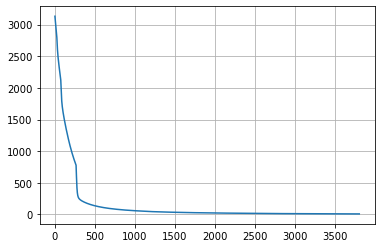

In [237]:
plt.plot(tf.reduce_mean(chi[200:,:,0],axis=1))
plt.grid()

(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)


Text(0.5, 1.0, 'chi_T')

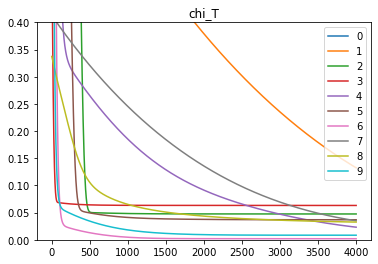

In [239]:
for i in range(10):
    print(np.array(chi).shape)
    plt.plot(chi[:,i,0],label=str(i))
    plt.ylim(0,0.4)
plt.legend()
plt.title('chi_T')

In [240]:
for s1,p1 in enumerate(params):
    p2=tf.concat(p1,axis=1)
    params[s1]=p2
params = np.array(params)
params.shape

(4001, 100, 7)

(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)


Text(0.5, 1.0, 'S_X')

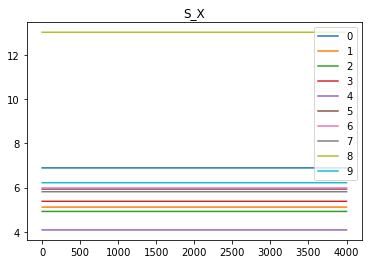

In [241]:
for i in range(0,10):
    print(np.array(chi).shape)
    plt.plot(params[:,i,-1],label=str(i))
plt.legend()
plt.title('S_X')

(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)
(4000, 100, 1)


Text(0.5, 1.0, 't0')

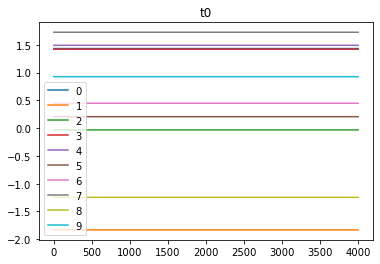

In [242]:
for i in range(10):
    print(np.array(chi).shape)
    plt.plot(params[:,i,0],label=str(i))
plt.legend()
plt.title('t0')

In [243]:
theta_r = ev_params[10:110,0]/180*math.pi


In [244]:
chi.shape

(4000, 100, 1)

Text(0.5, 1.0, 'theta')

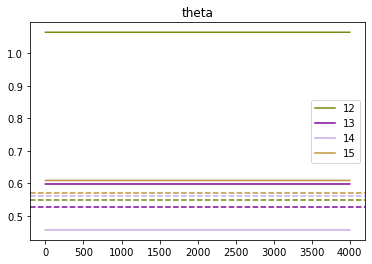

In [245]:
for i in range(12,16):
    c=np.random.rand(3)
    plt.plot(params[:,i,1],label=str(i),c=c)
    plt.axhline(y = theta_r[i], color =c, linestyle = '--') 
plt.legend()
plt.title('theta')

Text(0.5, 1.0, 'phi')

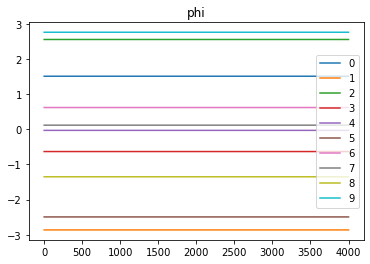

In [246]:
for i in range(10):
    plt.plot(params[:,i,2],label=str(i))
plt.legend()
plt.title('phi')

(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)


Text(0.5, 1.0, 'courve')

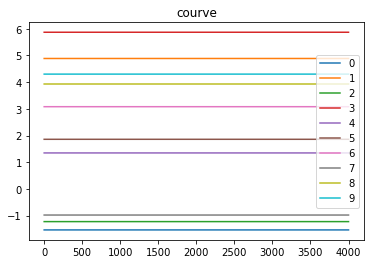

In [251]:
for i in range(10):
    print(params[:].shape)
    plt.plot(params[:,i,3],label=str(i))
plt.legend()
plt.title('courve')

(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)
(4001, 100, 7)


Text(0.5, 1.0, 'core_x')

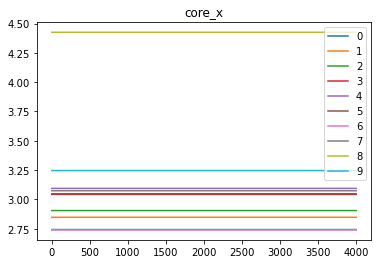

In [253]:
for i in range(10):
    print(params[:].shape)
    plt.plot(params[:,i,4],label=str(i))
plt.legend()
plt.title('core_x')

In [248]:
ev_params[:100][:20]

array([[ 39.2557 , 114.024  ],
       [ 36.0943 , 180.941  ],
       [  7.64452, 277.095  ],
       [  4.83893, 133.645  ],
       [  9.12421,  11.4863 ],
       [  4.09641, 129.41   ],
       [  6.02779, 299.594  ],
       [  5.67326, 328.879  ],
       [  5.62831,  42.347  ],
       [  4.77911, 189.887  ],
       [ 35.6531 , 325.147  ],
       [ 30.5317 , 117.835  ],
       [ 34.0435 , 355.499  ],
       [ 31.3505 , 283.593  ],
       [ 32.8267 , 141.962  ],
       [ 30.6234 , 173.66   ],
       [ 33.6671 , 353.896  ],
       [ 32.0517 , 227.489  ],
       [ 34.2791 ,  21.6844 ],
       [ 31.4452 , 161.245  ]], dtype=float32)

In [249]:
ang_res=tf.concat([rec.theta*180/3.14,tf.where(rec.phi*180/3.14>0,rec.phi*180/3.14,(rec.phi+3.14*2)*180/3.14)],axis=1)
ang_res[:20]

InvalidArgumentError: ConcatOp : Expected concatenating dimensions in the range [-1, 1), but got 1 [Op:ConcatV2] name: concat

In [126]:
rub_theta = ev_params[:100,0]
my_theta = ang_res[:,0]
info = tf.concat([tf.expand_dims(rub_theta,1),tf.expand_dims(my_theta,1),tf.expand_dims(my_theta-rub_theta,1),chi[-1]],1)
info

<tf.Tensor: shape=(100, 4), dtype=float32, numpy=
array([[ 39.2557    ,  34.37535   ,  -4.880348  ,   0.00299864],
       [ 36.0943    ,  34.549957  ,  -1.544342  ,   0.00018103],
       [  7.64452   ,   5.844272  ,  -1.8002477 ,   0.02166309],
       [  4.83893   ,   4.802578  ,  -0.03635216,   0.1446563 ],
       [  9.12421   ,  24.982243  ,  15.858032  ,   0.1197552 ],
       [  4.09641   ,   3.1873598 ,  -0.90905   ,   0.01383412],
       [  6.02779   ,   8.405071  ,   2.3772812 ,   0.03656435],
       [  5.67326   ,  21.69054   ,  16.01728   ,   0.00560927],
       [  5.62831   ,  14.517901  ,   8.889591  ,   0.01475409],
       [  4.77911   ,   8.972309  ,   4.193199  ,   0.00224062],
       [ 35.6531    ,  37.463524  ,   1.8104248 ,   0.0013078 ],
       [ 30.5317    ,  31.5051    ,   0.9734001 ,   0.01645587],
       [ 34.0435    ,  38.29748   ,   4.2539825 ,   0.00063643],
       [ 31.3505    ,  28.595621  ,  -2.754879  ,   0.00103641],
       [ 32.8267    ,  22.663748  , -10.

In [431]:
#Befor chi_L
diff= tf.reduce_mean(tf.math.abs(ev_params[10:110] -ang_res),axis=0)
print(diff)
print(tf.math.reduce_std(ev_params[10:110,0] -ang_res[:,0]),tf.math.reduce_std(ev_params[10:110,1] -ang_res[:,1]))

tf.Tensor([ 14.539997 145.38144 ], shape=(2,), dtype=float32)
tf.Tensor(17.939579, shape=(), dtype=float32) tf.Tensor(170.76843, shape=(), dtype=float32)


In [164]:
rec_0 = Reconstruction(data[10:110],tf.float32)
rec_0.place_params()

In [133]:
# phi problem
rub_phi = ev_params[10:110,1]
my_phi = ang_res[:,1]
real_phi = tf.cast(real_ang[10:110,1],tf.float32)
print(rub_phi.shape,my_phi.shape)

(100,) (100,)


In [134]:
# rubsov loss
info = tf.concat([tf.expand_dims(rub_phi,1),tf.expand_dims(real_phi,1),tf.expand_dims(real_phi-rub_phi,1)],1)
info

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[ 325.147     ,  323.625     ,   -1.5220032 ],
       [ 117.835     ,  117.254     ,   -0.5810013 ],
       [ 355.499     ,  355.848     ,    0.34899902],
       [ 283.593     ,  283.808     ,    0.21502686],
       [ 141.962     ,  143.354     ,    1.3919983 ],
       [ 173.66      ,  174.618     ,    0.95799255],
       [ 353.896     ,  357.138     ,    3.2420044 ],
       [ 227.489     ,  218.874     ,   -8.6150055 ],
       [  21.6844    ,   20.1942    ,   -1.4902    ],
       [ 161.245     ,  154.829     ,   -6.4160004 ],
       [ 129.853     ,  134.927     ,    5.074005  ],
       [   1.58276   ,    3.57281   ,    1.99005   ],
       [ 184.606     ,  186.847     ,    2.2409973 ],
       [ 166.44      ,  150.76      ,  -15.680008  ],
       [ 340.869     ,  346.152     ,    5.28302   ],
       [ 148.7       ,  152.153     ,    3.453003  ],
       [  40.8346    ,   39.8145    ,   -1.0200996 ],
       [ 277.232     ,  277.253 

In [135]:
info = tf.concat([tf.expand_dims(rub_phi,1),tf.expand_dims(my_phi,1),tf.expand_dims(my_phi-rub_phi,1)],1)
info

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[ 325.147     ,  107.07966   , -218.06735   ],
       [ 117.835     ,  180.87128   ,   63.036278  ],
       [ 355.499     ,  169.78464   , -185.71436   ],
       [ 283.593     ,  328.56363   ,   44.970642  ],
       [ 141.962     ,    4.168938  , -137.79306   ],
       [ 173.66      ,  177.0838    ,    3.4237976 ],
       [ 353.896     ,   33.769157  , -320.12683   ],
       [ 227.489     ,   10.948616  , -216.54037   ],
       [  21.6844    ,  267.50482   ,  245.82042   ],
       [ 161.245     ,  156.40791   ,   -4.837082  ],
       [ 129.853     ,  329.42093   ,  199.56793   ],
       [   1.58276   ,   82.96784   ,   81.38508   ],
       [ 184.606     ,  351.54596   ,  166.93996   ],
       [ 166.44      ,  285.98187   ,  119.54187   ],
       [ 340.869     ,  102.6989    , -238.17009   ],
       [ 148.7       ,  165.35      ,   16.65001   ],
       [  40.8346    ,  321.0761    ,  280.24152   ],
       [ 277.232     ,  219.6769

In [131]:
np.set_printoptions(suppress=True)
info[:,2]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([-218.06735   ,   63.036278  , -185.71436   ,   44.970642  ,
       -137.79306   ,    3.4237976 , -320.12683   , -216.54037   ,
        245.82042   ,   -4.837082  ,  199.56793   ,   81.38508   ,
        166.93996   ,  119.54187   , -238.17009   ,   16.65001   ,
        280.24152   ,  -57.5551    , -330.71786   ,   54.09642   ,
         13.831329  , -257.53552   ,  146.38818   ,  129.67915   ,
        185.80621   , -199.97517   , -292.21613   ,  -37.706543  ,
        309.47278   ,  -36.480087  ,  -50.91745   ,  244.98825   ,
       -147.26558   , -197.3659    ,  -71.333954  ,  -94.36228   ,
        -95.90592   ,  314.59976   , -308.42047   ,  -93.41144   ,
         24.183655  , -328.15134   , -162.23996   , -102.59543   ,
        104.21945   ,  -71.021866  ,    5.091675  , -211.9749    ,
       -153.25163   ,  -13.28157   ,  -40.71669   , -280.08646   ,
        -63.611267  ,  251.00093   , -164.8396    , -134.19861   ,
       -249.25

In [166]:
phi_0 = rec_0.phi * 180/pi
# phi_0

In [165]:
info_0 = tf.concat([tf.expand_dims(rub_phi,1),tf.expand_dims(phi_0,1),tf.expand_dims(phi_0-rub_phi,1)],1)
info_0

<tf.Tensor: shape=(100, 3), dtype=float32, numpy=
array([[ 325.147     ,  -33.339085  , -358.48608   ],
       [ 117.835     ,   84.94911   ,  -32.885887  ],
       [ 355.499     ,  -10.6808605 , -366.17984   ],
       [ 283.593     ,  -76.317474  , -359.91046   ],
       [ 141.962     ,  103.96337   ,  -37.998634  ],
       [ 173.66      ,  169.54025   ,   -4.119751  ],
       [ 353.896     ,  -43.18503   , -397.08102   ],
       [ 227.489     , -142.50192   , -369.9909    ],
       [  21.6844    ,   -1.2376478 ,  -22.922049  ],
       [ 161.245     ,  159.10197   ,   -2.1430206 ],
       [ 129.853     ,  139.70854   ,    9.855545  ],
       [   1.58276   ,    1.5303783 ,   -0.05238163],
       [ 184.606     ,  174.16695   ,  -10.439056  ],
       [ 166.44      ,  159.41281   ,   -7.027191  ],
       [ 340.869     ,  -27.761467  , -368.63046   ],
       [ 148.7       ,  156.59326   ,    7.893265  ],
       [  40.8346    ,   32.994385  ,   -7.840214  ],
       [ 277.232     ,  -68.2030

In [169]:
print(tf.concat([info[:,2:],info_0[:,2:]],1))

tf.Tensor(
[[   2.111908   -358.48608   ]
 [ -33.523155    -32.885887  ]
 [  -5.7290344  -366.17984   ]
 [   0.8772583  -359.91046   ]
 [ -38.469826    -37.998634  ]
 [  -5.173401     -4.119751  ]
 [ -35.588135   -397.08102   ]
 [ -10.035873   -369.9909    ]
 [ -21.532997    -22.922049  ]
 [  -3.25766      -2.1430206 ]
 [   8.585297      9.855545  ]
 [   0.14750206   -0.05238163]
 [ -11.338928    -10.439056  ]
 [  -7.412979     -7.027191  ]
 [  -8.156464   -368.63046   ]
 [   7.6427        7.893265  ]
 [  -7.038189     -7.840214  ]
 [  15.857697   -345.4351    ]
 [ -10.887634   -371.3482    ]
 [  -8.491959     -8.344208  ]
 [ -13.300346    -12.482742  ]
 [  29.111115   -331.57324   ]
 [ -24.053001    -24.379665  ]
 [  33.634544     34.091812  ]
 [ -81.61104     -81.77302   ]
 [-351.9647     -352.6139    ]
 [-326.15024    -326.2939    ]
 [  -1.7060852  -362.39197   ]
 [ 346.81488     -13.4753275 ]
 [  -2.1841812    -1.9374847 ]
 [  16.569153     16.626709  ]
 [ -25.334763    -25.649082 